In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

In [2]:
ps = pd.read_csv('googleplaystore.csv')
ps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
ps.shape

(10841, 13)

## Cleaning Data

In [4]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


## Clean the data -
Reviews, size, price at some leve all need some cleaning. Eg. in the Price column, some are pre pended with $ and some arent. A dive into data cleaning will show that 1 row is actually entered wrong in the sense that the column values are shifted left. Students could also create new columns out of given ones since they might want to turn size to a fixed unit, such as megabytes.  

In [5]:
# row where students should justify whether to drop since it's entered incorrectly (column values shifted right)
ps[ps.Reviews.str.find('M') != -1]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [6]:
ps = ps.drop(10472)

Students will likely find this since when looking at the distribution of Ratings, they will likely wonder why there is a single point that is causing the rating axis to be so large

## Univariate Analysis - 
Can look at distribution of categories, number of reviews, app sizes and so on. 


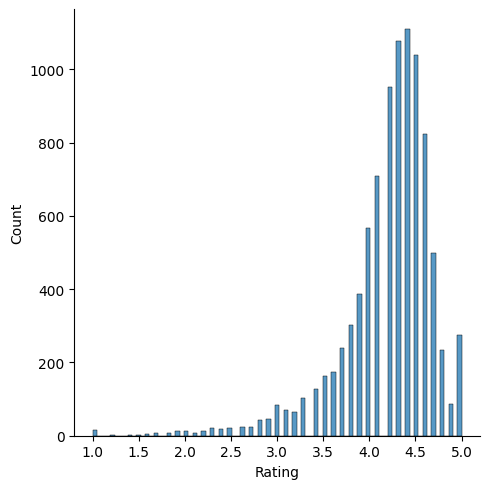

In [7]:
sns.displot(ps, x='Rating')

## Bivariate Analysis - 
eg. Can look at distribution of ratings for apps that are paid vs not paid, 

In [8]:
ps['is_paid'] = ps['Price'].str.replace('$', '').astype(float) == 0

/var/folders/42/7620rj0s40l61g76z97k379m0000gn/T/ipykernel_41760/2691133224.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ps['is_paid'] = ps['Price'].str.replace('$', '').astype(float) == 0


In [9]:
top_10_categories = ps.Category.value_counts().sort_values(ascending=False)[:10].index
top_10_categories

Index(['FAMILY', 'GAME', 'TOOLS', 'MEDICAL', 'BUSINESS', 'PRODUCTIVITY',
       'PERSONALIZATION', 'COMMUNICATION', 'SPORTS', 'LIFESTYLE'],
      dtype='object')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'BUSINESS'),
  Text(1, 0, 'COMMUNICATION'),
  Text(2, 0, 'LIFESTYLE'),
  Text(3, 0, 'GAME'),
  Text(4, 0, 'FAMILY'),
  Text(5, 0, 'MEDICAL'),
  Text(6, 0, 'SPORTS'),
  Text(7, 0, 'TOOLS'),
  Text(8, 0, 'PERSONALIZATION'),
  Text(9, 0, 'PRODUCTIVITY')])

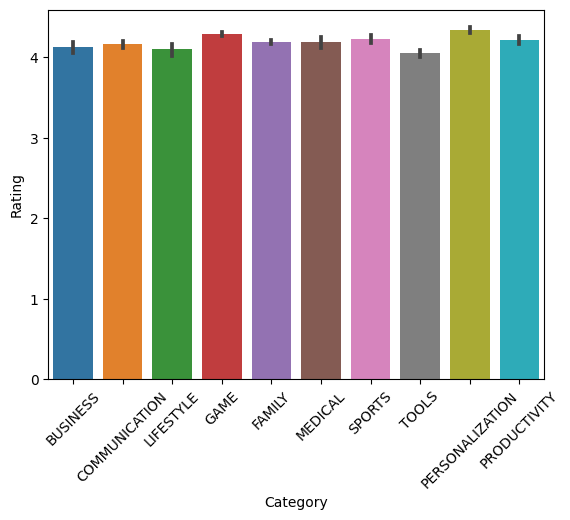

In [10]:
sns.barplot(x='Category', y='Rating', data=ps[ps.Category.isin(top_10_categories)])
plt.xticks(rotation=45)

## Interesting Aggregate
Can aggregate based on Category, Content Rating, and even columns that they can create such as bins of price, size, and number of installs and how that affects rating

## Missingness


In [11]:
def assess_missingness(data,focus_col,compare_col,stat="tvd",n_repetitions=1000):
    def tvd(data,missing_col,compare_col):
        pivoted = (
            shuffled
            .pivot_table(index=missing_col, columns=compare_col, aggfunc='size')
            .apply(lambda x: x / x.sum(), axis=1)
        )

        tvd = pivoted.diff().iloc[-1].abs().sum() / 2
        return tvd
    
    def ks_test(data,missing_col,compare_col):
        missing_data = data.loc[data[missing_col],compare_col]
        nonmissing_data = data.loc[~data[missing_col],compare_col]
        return ks_2samp(missing_data, nonmissing_data).pvalue
    
    shuffled = data.copy()
    missing_col = focus_col+'_missing'
    shuffled[missing_col] = shuffled[focus_col].isna()
    
    
    if stat == "ks":
        return ks_test(shuffled,missing_col,compare_col)
    
    if stat == "tvd":
        obs_tvd = tvd(data,missing_col,compare_col)
        tvds = []
        for _ in range(n_repetitions):

            # Shuffling genders and assigning back to the DataFrame
            shuffled[compare_col] = np.random.permutation(shuffled[compare_col])
            tvds.append(tvd(shuffled,missing_col,compare_col))
        pval = np.mean(np.array(tvds) >= obs_tvd)
        return pval

In [12]:
# column 0 = prop missingness, column 1 = number of missingness
pd.concat((ps.isnull().mean(), ps.isnull().sum()), axis=1)

,0,1
App,0.000000,0
Category,0.000000,0
Rating,0.135978,1474
Reviews,0.000000,0
Size,0.000000,0
Installs,0.000000,0
Type,0.000092,1
Price,0.000000,0
Content Rating,0.000000,0
Genres,0.000000,0


Since Current Ver and Android Ver has too little number of missing values, I think it's only reasonable for students to conduct missingess test on Rating w.r.t other columns

In [13]:
null_rating = ps[ps['Rating'].isnull()]
null_rating.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,is_paid
23,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61,7.0M,"100,000+",Free,0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up,True
113,Wrinkles and rejuvenation,BEAUTY,NaN,182,5.7M,"100,000+",Free,0,Everyone 10+,Beauty,"September 20, 2017",8.0,3.0 and up,True
123,Manicure - nail design,BEAUTY,NaN,119,3.7M,"50,000+",Free,0,Everyone,Beauty,"July 23, 2018",1.3,4.1 and up,True
126,Skin Care and Natural Beauty,BEAUTY,NaN,654,7.4M,"100,000+",Free,0,Teen,Beauty,"July 17, 2018",1.15,4.1 and up,True
129,"Secrets of beauty, youth and health",BEAUTY,NaN,77,2.9M,"10,000+",Free,0,Mature 17+,Beauty,"August 8, 2017",2.0,2.3 and up,True


In [14]:
ps[~ps['Rating'].isnull()]['Content Rating'].value_counts(normalize=True)

Everyone           0.792227
Teen               0.115738
Mature 17+         0.049221
Everyone 10+       0.042387
Adults only 18+    0.000320
Unrated            0.000107
Name: Content Rating, dtype: float64

In [15]:
null_rating['Content Rating'].value_counts(normalize=True)

Everyone        0.877883
Teen            0.084125
Mature 17+      0.025780
Everyone 10+    0.011533
Unrated         0.000678
Name: Content Rating, dtype: float64

In [16]:
# Can see that Rating is dependent with Content Rating
# This kind of makes sense if we think from the angle that people are not likely to rate mature 17+ 
# apps since I think reviewing an app is public?

assess_missingness(ps, "Rating", "Content Rating")

0.0

In [17]:
ps['Reviews_cleaned'] = ps['Reviews'].astype(int)
ps['Price_cleaned'] = ps.Price.str.replace('$', '').astype(float)

/var/folders/42/7620rj0s40l61g76z97k379m0000gn/T/ipykernel_41760/1338718845.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ps['Price_cleaned'] = ps.Price.str.replace('$', '').astype(float)


In [18]:
# Can see that Rating is likely not dependent with the price depending on level of alpha one would choose. 
# Note that I did go through all the other variables and I couldn't find one that is clearly MCAR (p-value that is very high)
assess_missingness(ps, "Rating", "Price_cleaned", stat='ks')

0.09039202263327122

## Hypothesis Test 
Sample questions may include
1. Do apps with more than 1 million installs have better ratings?
2. Do paid apps have higher Rating on average?
3. Is the distributions of Category the same between Free and Paid apps?

In [19]:
test_pivot = ps.pivot_table(index='is_paid', columns='Category', aggfunc='size', fill_value=0)
norm_pivot = test_pivot.apply(lambda x: x / x.sum(), axis=1)
norm_pivot

Category,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,...,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER
is_paid,,,,,,,,,,,,,,,,,,,,,
False,0.003750,0.003750,0.000000,0.035000,0.017500,0.000000,0.033750,0.00875,0.005000,0.002500,...,0.103750,0.027500,0.035000,0.002500,0.003750,0.030000,0.097500,0.015000,0.005000,0.010000
True,0.006175,0.008167,0.005279,0.020219,0.044422,0.005976,0.035857,0.02261,0.015139,0.014641,...,0.030777,0.031175,0.039442,0.025697,0.029084,0.035857,0.076195,0.024502,0.017032,0.007371


<AxesSubplot:ylabel='Category'>

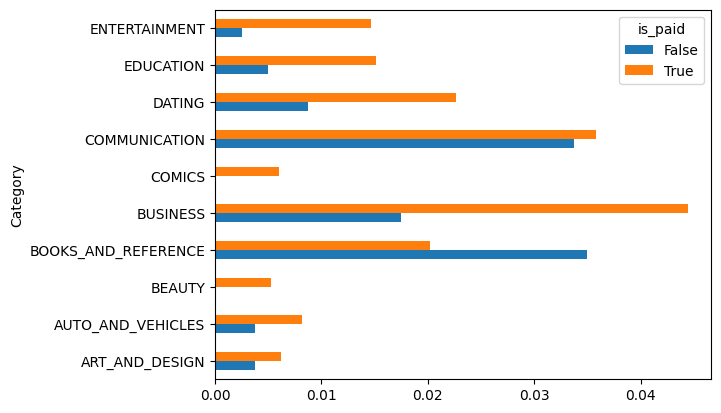

In [21]:
# below is plot of the distribution based on the first 10 categories
norm_pivot.iloc[:,:10].T.plot(kind='barh')


In [22]:
def tvd_stat(df):
    ''' computes tvd based on number of observations split on states between cause_categoryies'''
    pivot = df.pivot_table(index='is_paid', columns='Category', aggfunc='size', fill_value=0)
    norm_pivot = pivot.apply(lambda x: x / x.sum(), axis=1)
    tvd = norm_pivot.diff().abs().iloc[-1].sum() / 2
    return tvd

In [23]:
obs = tvd_stat(ps)
obs


0.2740388446215139

In [24]:
trials = 1000
shuffled = ps.copy()
tvds = []
for _ in range(trials):
    shuffled_col = ps['is_paid'].sample(frac=1, replace=False).reset_index(drop=True)
    
    shuffled['is_paid'] = shuffled_col

    tvd = tvd_stat(shuffled)
    tvds.append(tvd)
    
p_value = (tvds >= obs).mean()
p_value

0.0

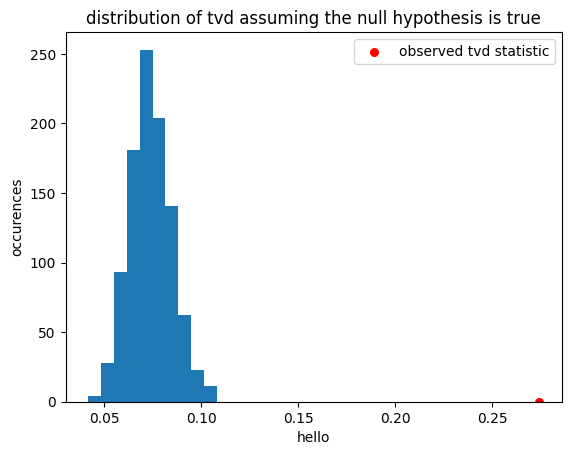

In [25]:
plt.hist(tvds)
plt.xlabel('hello')
plt.ylabel('occurences')
plt.title('distribution of tvd assuming the null hypothesis is true')
plt.scatter(obs, 0, color='red', s=30, label='observed tvd statistic')
plt.legend();

The analysis the students come up with would probably be a lot more interesting than this since they would probably be looking at "among popular apps, do paid / free ones have same distribution of categories?" Then they would involve some type of qualitative analysis on how to determine what's popular which they may need to do some research beyond the dataset

## Concern
I think my main concern with the dataset is that it doesn't really have that many columns that are very informative. Essentially there are really only 9 interesting columns and I'm not sure if that's too little for the class as I remember outages and NYPD datasets are more complex and perhaps can be a lot more rich in analysis due to various questions that can be asked

On the other hand, I think students can then focus on what are interesting aggregates to make their analysis meaningful, such as determining meaningful ways to bin current columns, and how the numerical columns may be numerical but really could be categorical due to the data generating process and how pricing on apps are very step-funciton like. They can also think about how to filter apps that aren't necessarily representative of Ratings / user base such as apps that are in 'niche' categories or apps that are not 'popular'

## Project 5 


### Ones that should probably result in decent performing models
1. Predict Rating
2. Predict Category of App 
3. Predictice Price





### Ones that probably result in bad/not high performing models
1. Predicting # of Reviews (too granular and not enough other numerical columns)
2. Predicting Android Vers. of the app
3. Predicting when app was last updated

In [27]:
ps.Type.value_counts()

Free    10039
Paid      800
Name: Type, dtype: int64